# Chapter 8 Exercises

# Set up

## Python path

In [1]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [2]:
from csaps import csaps
import numpy as np
import pandas as pd
from patsy import dmatrix, build_design_matrices
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar
from scipy.stats import norm

import const
import utils

## Constants

## Set defaults

In [3]:
utils.set_default_plot_style()

# Exercise 8.6

Consider the bone mineral density data of Figure 5.6.

(a) Fit a cubic smooth spline to the relative change in spinal BMD, as a function of age.
Use cross-validation to estimate the optimal amount of smoothing.
Construct pointwise 90% confidence bands for the underlying function.

(b) Compute the posterior mean and covariance for the true function via (8.28), and compare the posterior bands to those obtained in (a).

(c) Compute 100 bootstrap replicates of the fitted curves, as in the bottom left panel of Figure 8.2.
Compare the results to those obtained in (a) and (b).

### Solution

In [4]:
# Load the bone data
bone_data = pd.read_csv('../data/bone.data', sep='\s+')
bone_data.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


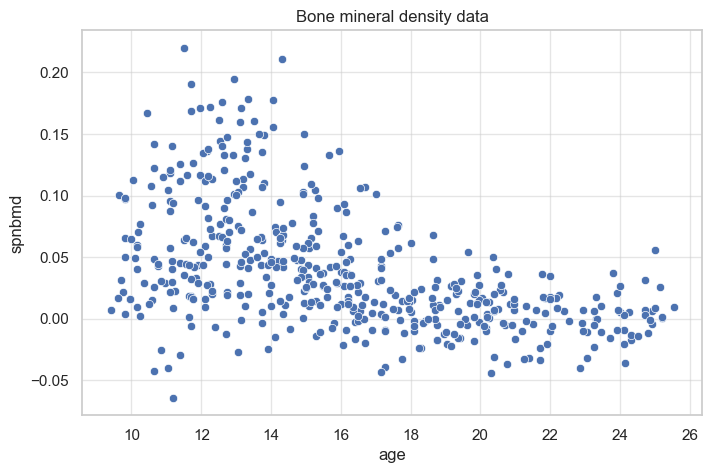

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(bone_data, x="age", y="spnbmd",ax=ax)
ax.set(title="Bone mineral density data");

### (a)

The class below automatically optimises the smoothing parameter using leave-one-out cross-validation.
Note that it simply selects the smoothing parameter that minimises LOO MSE rather than using the one standard error rule.

See Chapter 5 notes for an introduction to smoothing splines and the `csaps` package.

In [6]:
class SmoothingSpline():
    def __init__(self, x, y, smooth=None):
        self.x = x
        self.y = y
        self.x_unique, self.y_means, self.weights = self._deduplicate_x_values(
            self.x, self.y
        )

        # Automatically optimize the smooth parameter if not provided
        if smooth is None:
            self.smooth, self.dof, self.cv_error = self.optimize_smoothing()
            print(f"Automatically selected smooth={self.smooth:.6f} (DoF={self.dof:.2f}, CV error={self.cv_error:.6f})")
        else:
            self.smooth = smooth
            self.dof = self._calculate_dof(smooth)
            self.cv_error = self.calculate_loo_cv_mse(smooth)

        self.smoother_matrix = self._calculate_smoother_matrix()
        self.y_pred = self.smoother_matrix @ self.y

    def _deduplicate_x_values(self, x, y):
        """Deduplicate x values and average corresponding y values with weights w."""
        df = pd.DataFrame(
            index=x,
            data=np.array(y).T
        )
        means = df.groupby(level=0).mean()
        sizes = df.groupby(level=0).size()
        
        # if y is 1d we want to return a 1d output
        if means.shape[1] == 1:
            means = means.squeeze()
        
        return means.index.values, means.values, sizes.values
    
    def predict(self, x_new=None):
        """Predict values at new x points or at training points if not provided."""
        if x_new is None:
            x_new = self.x

        return csaps(self.x_unique, self.y_means, x_new, smooth=self.smooth, weights=self.weights, axis=-1, normalizedsmooth=True)
    
    def _calculate_smoother_matrix(self, smooth=None):
        """Calculate the smoother matrix for the given smoothing parameter."""
        if smooth is None:
            smooth = self.smooth
        
        n = len(self.x)
        Y = np.identity(n)
        _, Y_means, _ = self._deduplicate_x_values(self.x, Y)
        A = csaps(self.x_unique, Y_means, self.x, weights=self.weights, smooth=smooth, axis=0 ,normalizedsmooth=True)
        return (A + A.T)/2

    def _calculate_dof(self, smooth=None):
        """Calculate the effective degrees of freedom."""
        if smooth is None:
            smooth = self.smooth
        
        smoother_matrix = self._calculate_smoother_matrix(smooth)
        return np.trace(smoother_matrix)

    def calculate_loo_cv_mse(self, smooth=None):
        """Calculate leave-one-out cross-validation mean squared error."""
        if smooth is None:
            smooth = self.smooth

        smoother_matrix = self._calculate_smoother_matrix(smooth)
        y_pred = smoother_matrix @ self.y
        return np.mean(((self.y - y_pred) / (1 - np.diagonal(smoother_matrix))) ** 2)
    
    def optimize_smoothing(self):
        res = minimize_scalar(self.calculate_loo_cv_mse, bounds=(0, 1))
        """Find optimal smoothing parameter using cross-validation."""
        smooth = res.x
        cv_error = res.fun
        dof = self._calculate_dof(smooth)
        return smooth, dof, cv_error
            
    def perform_grid_search(self, smooth_values=None, plot_results=True):
        """Perform grid search over smoothing parameters values."""
        if smooth_values is None:
            smooth_values = np.linspace(0, 1, 100)

        cv_errors = np.array([self.calculate_loo_cv_mse(smooth) for smooth in smooth_values])
        dof_values = np.array([self._calculate_dof(smooth) for smooth in smooth_values])

        self.search_smooth_values = smooth_values
        self.search_cv_errors = cv_errors
        self.search_dof_values = dof_values

        if plot_results:
            ax = self.plot_grid_search_results(smooth_values, cv_errors, dof_values)
        else:
            ax = None

        return smooth_values, cv_errors, ax
    
    def get_training_predictions_with_std_errors(self):
        """Get fitted predictions and standard errors at the training data points.
    
        Calculates predictions and pointwise standard errors for the training data
        points using the smoother matrix. Returns sorted arrays for convenient plotting.
        """
        # Calculate predictions
        y_pred = self.smoother_matrix @ self.y
        
        # Calculate standard errors
        covariance = self.smoother_matrix @ self.smoother_matrix.T
        vars = np.diagonal(covariance)
        std_errs = np.sqrt(vars) / np.sqrt(len(self.x))
        
        # Sort for plotting
        order = np.argsort(self.x)
        
        return self.x[order], y_pred[order], std_errs[order]
    
    def plot_training_predictions(self, confidence_level=None, spline_color=None, ax=None):
        """Plot the cubic smoothing spline."""
        if spline_color is None:
            spline_color = sns.color_palette()[1]
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 5))

        sns.scatterplot(x=self.x, y=self.y, label="Data", ax=ax)

        x_sorted, y_pred, std_errs = self.get_training_predictions_with_std_errors()
        ax.plot(x_sorted, y_pred, color=spline_color, label="Smoothing spline")

        if confidence_level is not None:
            alpha = 1 - confidence_level
            z_score = norm.ppf(1 - alpha / 2)
            ax.fill_between(
                x_sorted, 
                y_pred - z_score * std_errs, 
                y_pred + z_score * std_errs, 
                color=spline_color,
                alpha=0.2,
                label=f"{confidence_level:.0%} CI",
            )

        ax.set(title=f"Smoothing Spline with {confidence_level:.0%} Confidence Bounds")
        ax.legend()
        return ax


    def plot_grid_search_results(self, smooth_values, cv_errors, dof_values, ax=None):
        """Plot the results of the grid search.
        
        We plot smoothing values on the bottom x-axis and effective degrees of freedom on the top x-axis.
        """
        # Calculate degrees of freedom for each smoothing value
        if dof_values is None:
            dof_values = np.array([self._calculate_dof(smooth) for smooth in smooth_values])
        
        # Use interpolation to map between smoothing values and degrees of freedom
        def _smooth_to_dof(smooth_arr):
            return np.interp(smooth_arr, smooth_values, dof_values)
        
        def _dof_to_smooth(dof_arr):
            return np.interp(dof_arr, dof_values, smooth_values)
        
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(x=smooth_values, y=cv_errors, ax=ax)
        ax.set(
            xlabel="Smoothing Parameter",
            ylabel="MSE",
            title="Leave-One-Out Cross-Validation"
        )

        secax = ax.secondary_xaxis('top', functions=(_smooth_to_dof, _dof_to_smooth))

        # Set ticks for the secondary x-axis at integer degrees of freedom
        int_dof_values = np.ceil(dof_values)
        dof_ticks = np.arange(np.min(int_dof_values), np.max(int_dof_values))
        secax.set(
            xticks=dof_ticks,
            xlabel="Effective Degrees of Freedom"
        )

        fig.tight_layout()

        return ax

Automatically selected smooth=0.001380 (DoF=6.83, CV error=0.001665)


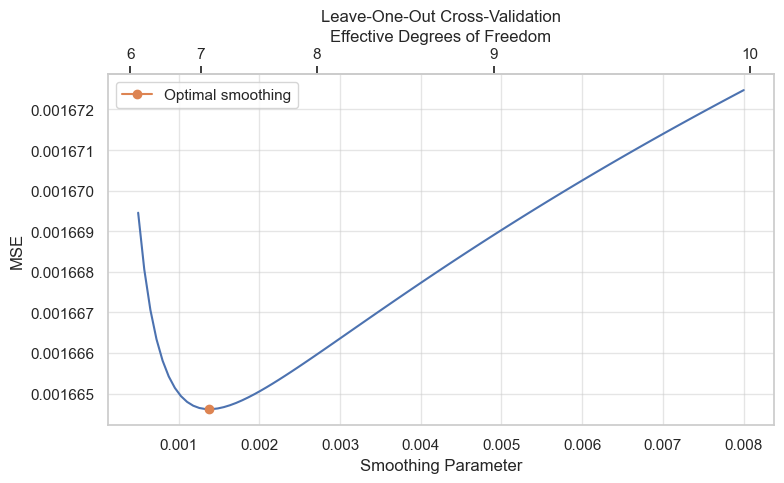

In [7]:
smoothing_spline_model = SmoothingSpline(bone_data['age'], bone_data['spnbmd'])

smooth_values = np.linspace(0.0005, 0.008, 100)
_, _, ax = smoothing_spline_model.perform_grid_search(smooth_values)
ax.plot(smoothing_spline_model.smooth, smoothing_spline_model.cv_error, marker='o', label="Optimal smoothing")
ax.legend();

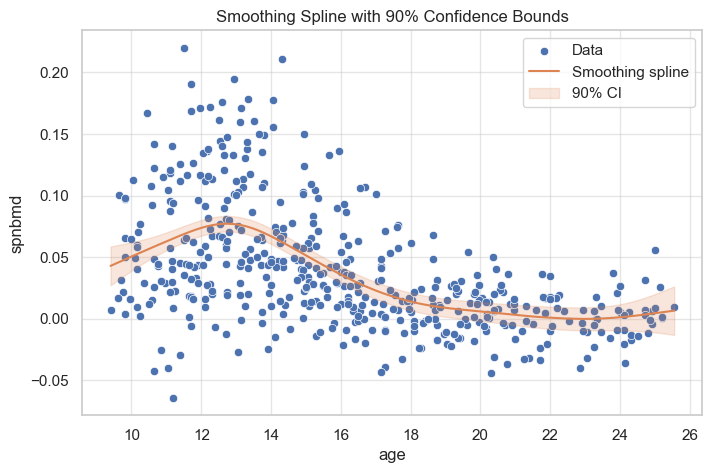

In [8]:
smoothing_spline_model.plot_training_predictions(confidence_level=0.90);

### (b)

I believe that the questions wants me to use the methods in section 8.3 to fit a natural cubic spline to the data.
That is, I think it wants me to use a 'normal' natural cubic spline with set degrees of freedom and knots at the quantiles of the data, rather than putting knots at each x-value as with smoothing splines.
When I've tried the latter I end up with a very un-smooth regression function - the prior parameter $\tau$ seems to control how much the spline is able to vary at each individual point, rather than controlling how it varies between the knots.

Before we get to the code it's worth clarifying some things in the text.
- $\beta$ is the vector of spline coefficients. We take a Bayesian view and so give this a prior $\beta \sim \text{N}\left(0, \tau I\right)$.
- $h(x)=(h_j(x))$ is the vector obtained by evaluating a point $x$ on the spline bases $h_j(x)$.
- $\mu(x)$ is the regression function $\mu(x) = \beta^T h(x)$. This inherits a distribution from $\beta$.

So our model for the data is $y(x) \sim~ \text{N}\left(\mu(x), \sigma^2\right)$.
In a proper Bayesian model we would put a prior on $\sigma$, but here we either specify it directly or estimate it from the data.

In (8.27) and (8.28) the text gives formulas for the posterior mean and covariance of $\beta$ and $\mu(x)$, both of which are normally distributed.
The latter follows directly from the former using the definition $\mu(x) = \beta^T h(x)$.
Note that everything here concerns the mean of $y$ - we are dealing with priors and posteriors, _not_ prior predictives and posterior predictives.

Finally, let's clarify the naming in the function below:
- We generally use `coefficient` (or `coef`) to represent $\beta$
- We use `regression_function` to mean $\mu$
- We call $\mathbf{H}$ the `design_matrix`
- We call the function $x \mapsto h(x)$ `evaluate_basis`

For consistency we use `confidence_level` to control the width of the posterior bands in the plots.
Since $\mu(x)$ is normally distributed we are just plotting posterior percentiles.
Note however that these are *pointwise* intervals - they only have the claimed coverage at each point, not overall.

In [9]:
class BayesianCubicSplines():
    def __init__(self, x, y, dof, tau, sigma=None):
        self.x = x
        self.y = y
        self.dof = dof
        self.tau = tau
        self.sigma = self._estimate_sigma() if sigma is None else sigma

        # priors are zero-centered, so we center y
        self.y_centered, self.y_mean = self._center_y(self.y)

        self.design_matrix = self._create_design_matrix()

        # calculate prior and posterior for coefficients
        self.coef_prior_mean, self.coef_prior_cov = self._calculate_coefficient_prior()
        self.coef_posterior_mean, self.coef_posterior_cov = self._calculate_coefficient_posterior()

    def _center_y(self, y):
        """Center the y values by subtracting the mean (priors in the book are centered at zero)."""
        y_mean = np.mean(y)
        return y - y_mean, y_mean

    def _estimate_sigma(self):
        """Estimate sigma from the sample standard deviation."""
        return np.std(self.y, ddof=1)

    def _calculate_coefficient_prior(self):
        prior_mean = np.zeros(self.dof)
        prior_cov = np.eye(self.dof) * self.tau
        return prior_mean, prior_cov

    def _calculate_coefficient_posterior(self):
        inv_cov = np.linalg.inv(self.coef_prior_cov)
        mat = np.linalg.inv(self.design_matrix.T @ self.design_matrix + self.sigma**2 * inv_cov)

        posterior_mean = mat @ (self.design_matrix.T @ self.y_centered)
        posterior_cov = mat * self.sigma**2

        return posterior_mean, posterior_cov
    
    def _create_design_matrix(self):
        """Create the design matrix for cubic splines."""
        return dmatrix(f"cr(x, df={self.dof}) - 1", {"x": self.x})

    def evaluate_basis(self, x_eval):
        """Evaluate the basis functions at new x values."""
        return build_design_matrices([self.design_matrix.design_info], {"x": x_eval})[0]
    
    def predict(self, x_eval, coef):
        """Predict values at new x values using the provided coefficients."""
        basis_eval = self.evaluate_basis(x_eval)
        return coef @ basis_eval.T + self.y_mean
    
    def regression_function_prior_mean(self, x_eval):
        """Function giving the prior mean at given x-values."""
        return self.predict(x_eval, self.coef_prior_mean)

    def regression_function_prior_cov(self, x_eval):
        """Function giving the prior covariance at given x-values"""
        basis_eval = self.evaluate_basis(x_eval)
        return basis_eval @ self.coef_prior_cov @ basis_eval.T
    
    def regression_function_posterior_mean(self, x_eval):
        """Function giving the posterior mean at given x-values."""
        return self.predict(x_eval, self.coef_posterior_mean)
    
    def regression_function_posterior_cov(self, x_eval):
        """Function giving the posterior covariance at given x-values."""
        basis_eval = self.evaluate_basis(x_eval)
        return basis_eval @ self.coef_posterior_cov @ basis_eval.T
    
    def plot_prior(self, confidence_level=0.9, n_samples=0, title=None, ax=None):
        """Plot the prior mean with a credible interval and samples."""
        return self._plot_distribution("prior", n_samples, confidence_level, title, ax)

    def plot_posterior(self, confidence_level=0.9, n_samples=0, title=None, ax=None):
        """Plot the posterior mean with a credible interval and samples."""
        return self._plot_distribution("posterior", n_samples, confidence_level, title, ax)
    
    def _plot_distribution(self, distribution="prior", n_samples=0, confidence_level=0.9, title=None, ax=None):
        """Plot the mean, a credible interval, and samples from the prior or posterior of the regression function."""
        if distribution not in ["prior", "posterior"]:
            raise ValueError("distribution must be either 'prior' or 'posterior'")
        
        # get the means/covariances for the prior/posterior
        regression_function_mean = getattr(self, f"regression_function_{distribution}_mean")
        regression_function_cov = getattr(self, f"regression_function_{distribution}_cov")
        coef_mean = getattr(self, f"coef_{distribution}_mean")
        coef_cov = getattr(self, f"coef_{distribution}_cov")
            
        if ax is None:
            _, ax = plt.subplots(figsize=(8, 5))

        # plot data
        sns.scatterplot(x=self.x, y=self.y, ax=ax, label="Data")

        x_eval = np.linspace(np.min(self.x), np.max(self.x), 100)

        # Plot mean and pointwise std
        mean = regression_function_mean(x_eval)
        ax.plot(x_eval, mean, color=sns.color_palette()[1], label=f"{distribution.capitalize()} mean")

        cov = regression_function_cov(x_eval)
        std = np.sqrt(np.diag(cov))
        alpha = 1 - confidence_level
        z_score = norm.ppf(1 - alpha / 2)
        ax.fill_between(
            x_eval,
            mean - z_score * std,
            mean + z_score * std,
            color=sns.color_palette()[1],
            alpha=0.2, 
            label=f"{confidence_level:.0%} CI",
        )

        if n_samples > 0:
            # Sample coefficients
            beta_sample = np.random.multivariate_normal(
                mean=coef_mean,
                cov=coef_cov,
                size=n_samples
            )

            y_eval = self.predict(x_eval, beta_sample)
            ax.plot(x_eval, y_eval.T, alpha=0.5)

        ax.set(title=f"{distribution.capitalize()} Distribution of Regression Function" if title is None else title)
        ax.legend()
                
        return ax

Plot some prior and posterior samples using a sensible number of degrees of freedom from part (a).

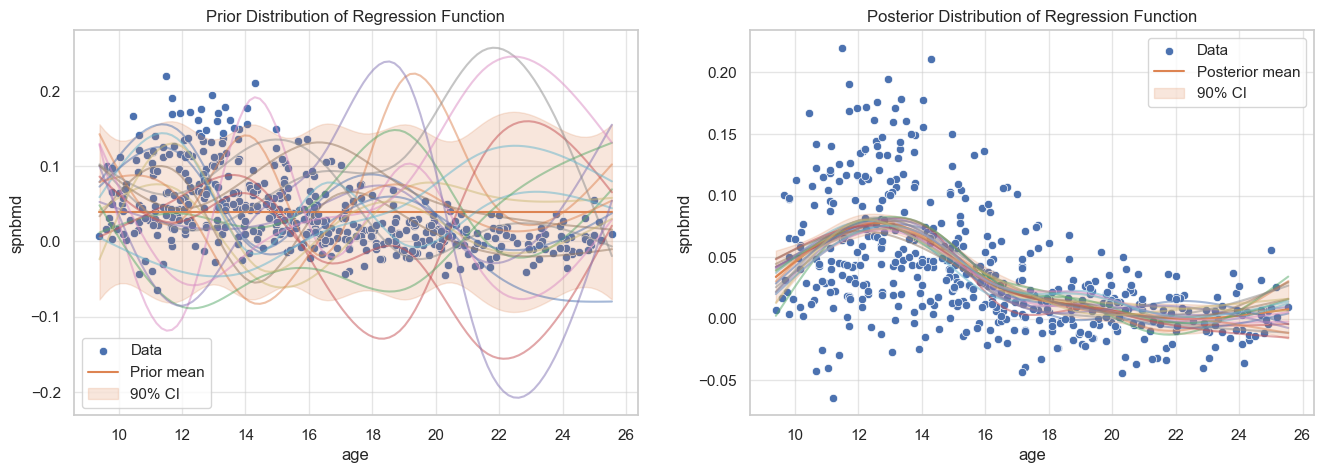

In [10]:
bayesian_model = BayesianCubicSplines(
    bone_data['age'],
    bone_data['spnbmd'],
    dof=7,
    tau=0.005,
)
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))
bayesian_model.plot_prior(n_samples=20, confidence_level=0.9, title="Prior Distribution of Regression Function", ax=axs[0])
bayesian_model.plot_posterior(n_samples=20, confidence_level=0.9, title="Posterior Distribution of Regression Function", ax=axs[1]);

Note that in the prior, the pointwise standard deviation varies, giving more freedom in areas with fewer knots.

The posterior variance is considerably lower.

We can visualise how the spline fit varies with more degrees of freedom.

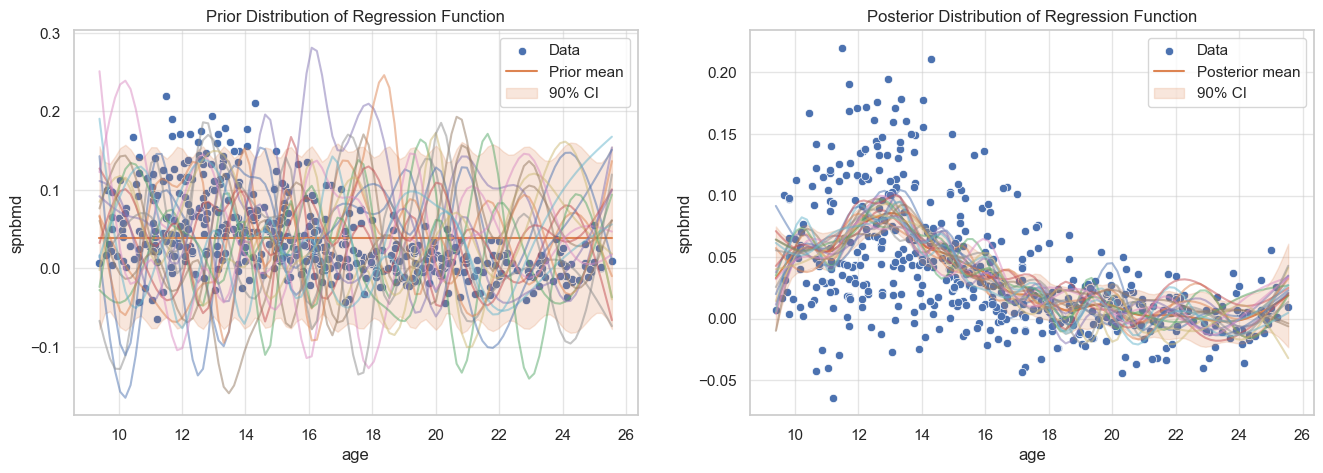

In [11]:
bayesian_model = BayesianCubicSplines(
    bone_data['age'],
    bone_data['spnbmd'],
    dof=20,
    tau=0.005,
)
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))
bayesian_model.plot_prior(n_samples=20, title="Prior Distribution of Regression Function", ax=ax[0])
bayesian_model.plot_posterior(n_samples=20, title="Posterior Distribution of Regression Function", ax=ax[1]);

Finally let's see how changing the prior (represented by $\tau$) affects the prior and posterior fits.

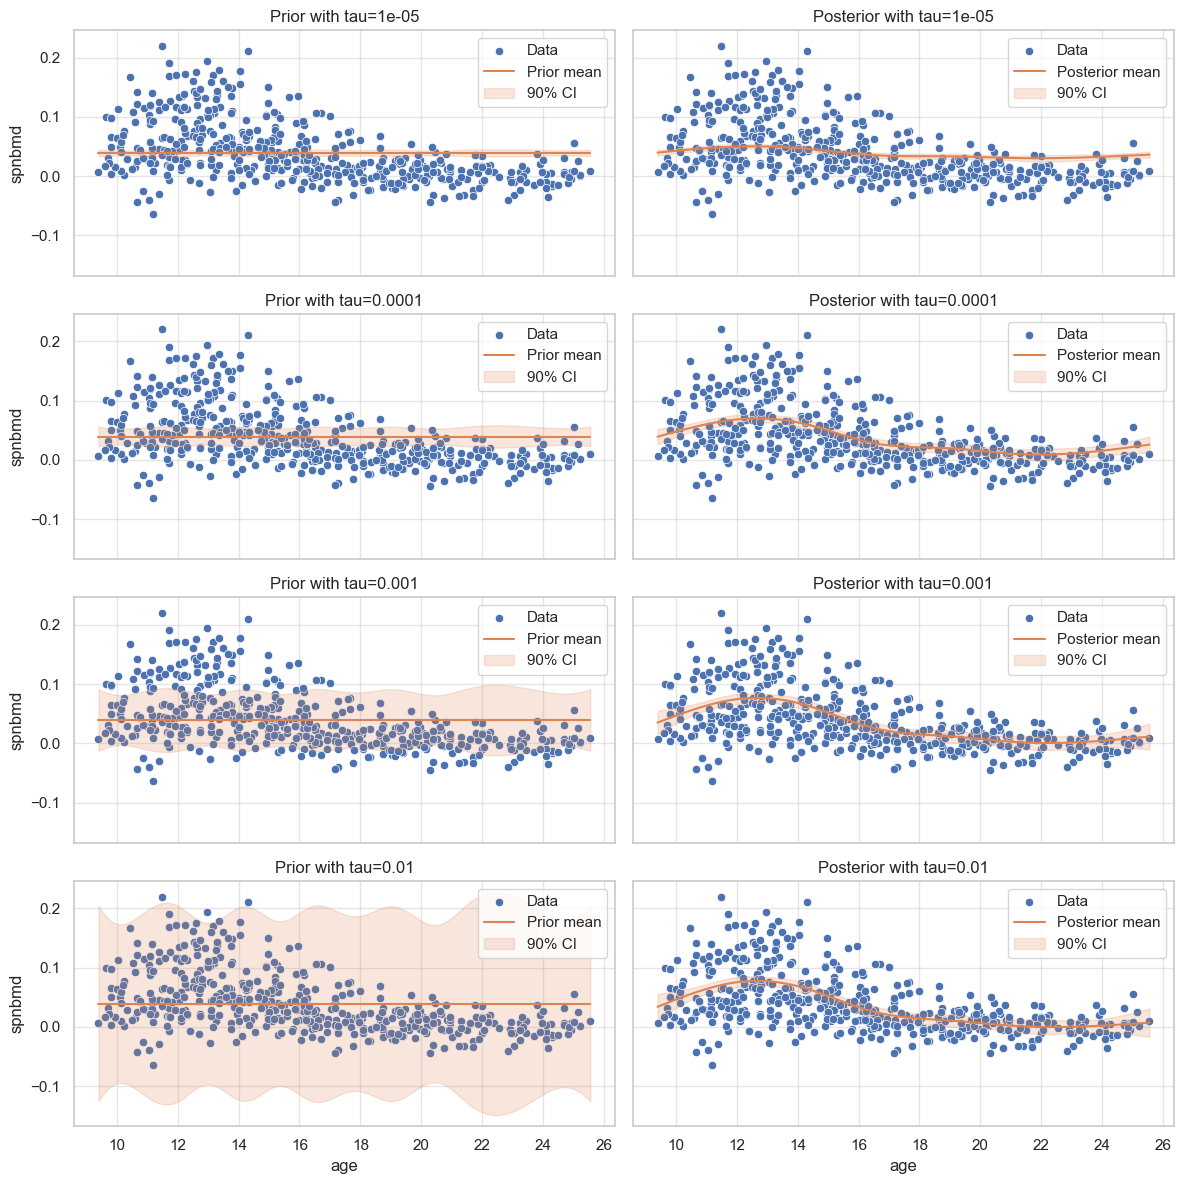

In [12]:
taus = np.logspace(-5, -2, 4)

nrows = len(taus)
fig, axs = plt.subplots(nrows=nrows, ncols=2, sharex=True, sharey=True, figsize=(12, 3*nrows))

for i, tau in enumerate(taus):
    bayesian_spline_model = BayesianCubicSplines(
        bone_data['age'],
        bone_data['spnbmd'],
        dof=7,
        tau=tau,
    )
    bayesian_spline_model.plot_prior(ax=axs[i, 0], title=f"Prior with tau={tau}")
    bayesian_spline_model.plot_posterior(ax=axs[i, 1], title=f"Posterior with tau={tau}")
    
fig.tight_layout()

For small $\tau$ the fitted curve is extremely flat with low variance.
As $\tau$ increases the posterior converges towards the fit in (a).

Finally let's directly compare the posterior bands with the confidence intervals in (a).

Automatically selected smooth=0.001380 (DoF=6.83, CV error=0.001665)


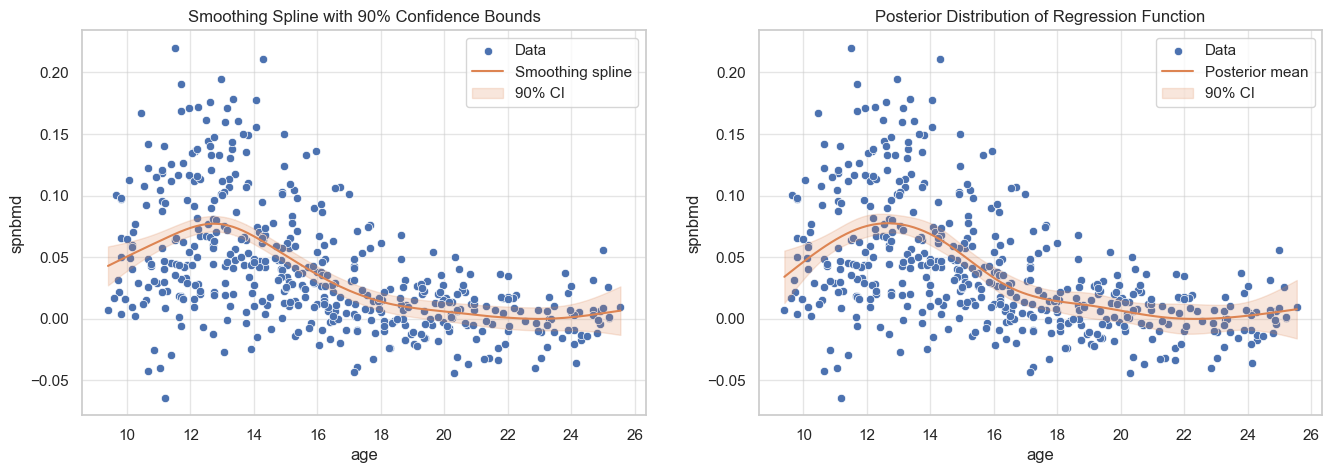

In [13]:
smoothing_spline_model = SmoothingSpline(bone_data['age'], bone_data['spnbmd'])
bayesian_model = BayesianCubicSplines(
    bone_data['age'],
    bone_data['spnbmd'],
    dof=7,
    tau=0.005
)

fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

smoothing_spline_model.plot_training_predictions(confidence_level=0.90, ax=axs[0])
bayesian_model.plot_posterior(confidence_level=0.9, ax=axs[1]);

Overall they are very similar.
Possibly the Bayesian implementation has wider confidence bounds.